In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     TimeSeriesSplit)

from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import validation_curve, learning_curve

plt.style.use('ggplot')

In [2]:
ETHBTC = pd.read_csv('data/0_klines_ETHBTC_15m.csv')
ETHBTC.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,pair_id
0,2017-07-14 04:00:00+00:00,0.080000,0.086400,0.080000,0.086400,8.752,2017-07-14 04:14:59.999,0.728274,26,3.268,0.282355,0
1,2017-07-14 04:15:00+00:00,0.085289,0.086000,0.085128,0.085811,61.042,2017-07-14 04:29:59.999,5.217079,33,2.738,0.235027,0
2,2017-07-14 04:30:00+00:00,0.085811,0.086380,0.085811,0.086314,53.769,2017-07-14 04:44:59.999,4.631740,41,21.225,1.829643,0
3,2017-07-14 04:45:00+00:00,0.086314,0.086380,0.086309,0.086347,42.818,2017-07-14 04:59:59.999,3.697253,61,7.948,0.686295,0
4,2017-07-14 05:00:00+00:00,0.085874,0.086205,0.084608,0.084680,16.520,2017-07-14 05:14:59.999,1.404228,15,1.176,0.100914,0


In [3]:
ETHBTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141765 entries, 0 to 141764
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   open_time                     141765 non-null  object 
 1   open                          141765 non-null  float64
 2   high                          141765 non-null  float64
 3   low                           141765 non-null  float64
 4   close                         141765 non-null  float64
 5   volume                        141765 non-null  float64
 6   close_time                    141765 non-null  object 
 7   quote_asset_volume            141765 non-null  float64
 8   number_of_trades              141765 non-null  int64  
 9   taker_buy_base_asset_volume   141765 non-null  float64
 10  taker_buy_quote_asset_volume  141765 non-null  float64
 11  pair_id                       141765 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory us

In [4]:
ETHBTC['time'] = pd.to_datetime(ETHBTC['open_time'])
ETHBTC.set_index(ETHBTC['time'], inplace=True)
pd.concat([ETHBTC.head(2), ETHBTC.tail(2)])

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,pair_id,time
time,,,,,,,,,,,,,
2017-07-14 04:00:00+00:00,2017-07-14 04:00:00+00:00,0.080000,0.086400,0.080000,0.086400,8.752,2017-07-14 04:14:59.999,0.728274,26,3.268,0.282355,0,2017-07-14 04:00:00+00:00
2017-07-14 04:15:00+00:00,2017-07-14 04:15:00+00:00,0.085289,0.086000,0.085128,0.085811,61.042,2017-07-14 04:29:59.999,5.217079,33,2.738,0.235027,0,2017-07-14 04:15:00+00:00
2021-08-03 23:30:00+00:00,2021-08-03 23:30:00+00:00,0.065474,0.065639,0.065420,0.065631,499.524,2021-08-03 23:44:59.999,32.731950,1212,250.103,16.389606,0,2021-08-03 23:30:00+00:00
2021-08-03 23:45:00+00:00,2021-08-03 23:45:00+00:00,0.065636,0.066020,0.065502,0.065666,2568.229,2021-08-03 23:59:59.999,168.911954,4544,1264.474,83.158849,0,2021-08-03 23:45:00+00:00


In [5]:
prices = pd.DataFrame(data={'ETHBTC':ETHBTC['close']})
prices.head(2)

,ETHBTC
time,
2017-07-14 04:00:00+00:00,0.086400
2017-07-14 04:15:00+00:00,0.085811


In [21]:
prices.tail()

,ETHBTC
time,
2021-08-03 22:45:00+00:00,0.065533
2021-08-03 23:00:00+00:00,0.065562
2021-08-03 23:15:00+00:00,0.065474
2021-08-03 23:30:00+00:00,0.065631
2021-08-03 23:45:00+00:00,0.065666


In [6]:
len(prices)

141765

In [36]:
np.logspace(-5,5,11)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])

In [32]:
np.logspace(-5,5,11)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])

In [53]:
class ScikitVectorBacktester(object):
    ''' Class for the vectorized backtesting of
    machine learning-based trading strategies.

    Attributes
    ==========
    symbol: str
        TR RIC (financial instrument) to work with
    start: int
        start date index for data selection
    end: int
        end date index for data selection
    amount: int, float
        amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g., 0.5% = 0.005) per trade
    model: str
        either 'regression' or 'logistic'
    
    TODO: add 'NN' model

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    select_data:
        selects a sub-set of the data
    prepare_features:
        prepares the features data for the model fitting
    fit_model:
        implements the fitting step
    run_strategy:
        runs the backtest for the regression-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def __init__(self, symbol, start, end, amount, tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = prices.iloc[self.start:self.end]
        raw['returns'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()

    def select_data(self, start, end):
        ''' Selects sub-sets of the financial data.
        '''
        data = self.data[start:end+1].copy()
        return data

    def prepare_features(self, start, end):
        ''' Prepares the feature columns for the regression and prediction steps.
        '''
        self.data_subset = self.select_data(start, end)
        self.feature_columns = []
        for lag in range(1, self.lags + 1):
            col = 'lag_{}'.format(lag)
            self.data_subset[col] = self.data_subset['returns'].shift(lag)
            self.feature_columns.append(col)
            
        self.data_subset['momentum'] = self.data_subset['returns'].rolling(4).mean().shift(1)
        self.data_subset['volatility'] = self.data_subset['returns'].rolling(20).std().shift(1) 
        self.data_subset['distance'] = (self.data_subset['ETHBTC'] - self.data_subset['ETHBTC'].rolling(50).mean()).shift(1)
        self.data_subset.dropna(inplace=True)

        self.feature_columns.extend(['momentum', 'volatility', 'distance'])
            
        # binarize the outcome: 1 if return positive, 0 otherwise
        # this is to make CV with use of auc roc metrics work..
        self.data_subset['label'] = (self.data_subset['returns'] > 0).astype(int)
        
        self.data_subset.dropna(inplace=True)
        
        print(f'label counts:{self.data_subset.label.value_counts()}\n')

    def fit_model(self, start, end):
        ''' Implements the fitting step.
        '''
        self.prepare_features(start, end)
        
        self.model = linear_model.LogisticRegression(C=1e6,
                solver='lbfgs', multi_class='ovr', max_iter=1000)
        
        self.model.fit(self.data_subset[self.feature_columns],
                       self.data_subset['label'])
        
    def grid_search_cv(self, start, end):
        ''' Implements the fitting step.
        '''
        
        self.prepare_features(start, end)
        
        pipe = Pipeline([('model', linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000))])
        
#         Cs = [1e-5, 1, 10, 1e5]
        Cs = np.logspace(-5,5,11)
        
        param_grid = {'model__C': Cs}
        
        tscv = TimeSeriesSplit(n_splits=3)
        
        self.model = GridSearchCV(estimator=pipe,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=tscv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)
        
        self.model.fit(X=self.data_subset[self.feature_columns],
                       y=self.data_subset['label'])
        
        
    def plot_grid_search_cv_res(self, start_in, end_in, lags=3):
        
        self.lags = lags
        self.grid_search_cv(start_in, end_in)
        
        print("best params: ====")
        display(self.model.best_params_)
        print("best score: ====")
        display(self.model.best_score_)
#         print("cv results: ====")
#         display(self.model.cv_results_)
        
        # get results
        param_range = self.model.cv_results_['param_model__C'].data
        param_range = np.array(param_range, dtype=float)
#         print("param_range results: ====")
#         display(param_range)
        
        train_scores_mean = self.model.cv_results_['mean_train_score']
#         print("train_scores_mean results: ====")
#         display(train_scores_mean)
        
        train_scores_std = self.model.cv_results_['std_train_score']
#         print("train_scores_std results: ====")
#         display(train_scores_std)
        
#         print("band train -: ====")
#         display(train_scores_mean - train_scores_std)
        
#         print("band train +: ====")
#         display(train_scores_mean + train_scores_std)
        
        test_scores_mean = self.model.cv_results_['mean_test_score']
        test_scores_std = self.model.cv_results_['std_test_score']
        
#         print("test_scores_mean results: ====")
#         display(test_scores_mean)
        
#         print("test_scores_std results: ====")
#         display(test_scores_std)
        
#         print("band test -: ====")
#         display(test_scores_mean - test_scores_std)
        
#         print("band test +: ====")
#         display(test_scores_mean + test_scores_std)
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 4))
        
        # plot validation curve
        axes[0].set_title("Validation Curve")
        axes[0].set_xlabel(r"C")
        axes[0].set_ylabel(f"lag={lags}\nauc")
        axes[0].set_ylim(0.51, 0.55)
        lw = 2
        axes[0].semilogx(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
        axes[0].fill_between(param_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.2,
                         color="darkorange", lw=lw)
        axes[0].semilogx(param_range, test_scores_mean, label="Cross-validation score",
                     color="navy", lw=lw)
        axes[0].fill_between(param_range, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.2,
                         color="navy", lw=lw)
        axes[0].legend(loc="best")
        
        # learning curve
        X=self.data_subset[self.feature_columns]
        y=self.data_subset['label']
        
        tscv = TimeSeriesSplit(n_splits=3)
            
        train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(self.model, X, y, cv=tscv, n_jobs=-1,
                       train_sizes=np.linspace(.1, 1.0, 5),
                       return_times=True)
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)
        
        axes[1].grid()
        axes[1].set_title("Learning Curve")
        axes[1].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
        axes[1].fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color="g")
        axes[1].plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
        axes[1].plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
        axes[1].legend(loc="best")
    

    def run_strategy(self, start_in, end_in, start_out, end_out, lags=3, use_grid_seach=False):
        ''' Backtests the trading strategy.
        '''
        self.lags = lags
        
        if use_grid_seach:
            self.grid_search_cv(start_in, end_in)
            self.plot_grid_search_cv_res(start_in, end_in, lags)
        else:
            self.fit_model(start_in, end_in)
            
        self.prepare_features(start_out, end_out)
        prediction = self.model.predict(self.data_subset[self.feature_columns])
        self.data_subset['prediction'] = prediction
        self.data_subset['strategy'] = (self.data_subset['prediction'] *
                                        self.data_subset['returns'])
        # determine when a trade takes place
        trades = self.data_subset['prediction'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        self.data_subset['strategy'][trades] -= self.tc
        self.data_subset['creturns'] = (self.amount *
                        self.data_subset['returns'].cumsum().apply(np.exp))
        
        self.data_subset['cstrategy'] = (self.amount *
                        self.data_subset['strategy'].cumsum().apply(np.exp))
        
        self.results = self.data_subset
        self.bperf = self.results['creturns'].iloc[-1]
        # absolute performance of the strategy
        self.aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        self.operf = self.aperf - self.bperf
#         return round(aperf, 2), round(operf, 2)

    def plot_results(self, use_grid_seach=False):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
            
        title = f'{self.symbol} | TC = {self.tc:.4f} | lag={self.lags} | B-perf={self.bperf:.2f} | perf={self.aperf:.2f} | over-perf={self.operf:.2f}'
        self.results[['creturns', 'cstrategy']].plot(title=title, figsize=(6, 4))


<ipython-input-53-9a2f61302af0>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['returns'] = np.log(raw / raw.shift(1))


label counts:0    57770
1    55593
Name: label, dtype: int64

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.0s finished


label counts:0    57770
1    55593
Name: label, dtype: int64

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.0s finished


best params: ====


{'model__C': 1000.0}

best score: ====


0.5377549185049496

label counts:0    14494
1    13807
Name: label, dtype: int64

label counts:0    57770
1    55593
Name: label, dtype: int64


<ipython-input-53-9a2f61302af0>:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_subset['strategy'][trades] -= self.tc
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.6s finished


label counts:0    57770
1    55593
Name: label, dtype: int64

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.6s finished


best params: ====


{'model__C': 1e-05}

best score: ====


0.537555025665498

label counts:0    14494
1    13807
Name: label, dtype: int64



<ipython-input-53-9a2f61302af0>:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_subset['strategy'][trades] -= self.tc


label counts:0    57770
1    55593
Name: label, dtype: int64

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.3s finished


label counts:0    57770
1    55593
Name: label, dtype: int64

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.3s finished


best params: ====


{'model__C': 0.0001}

best score: ====


0.5353037997202282

label counts:0    14494
1    13807
Name: label, dtype: int64

label counts:0    57770
1    55593
Name: label, dtype: int64

Fitting 3 folds for each of 11 candidates, totalling 33 fits


<ipython-input-53-9a2f61302af0>:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_subset['strategy'][trades] -= self.tc
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.7s finished


label counts:0    57770
1    55593
Name: label, dtype: int64

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.9s finished


best params: ====


{'model__C': 1e-05}

best score: ====


0.5330690656011859

label counts:0    14494
1    13807
Name: label, dtype: int64



<ipython-input-53-9a2f61302af0>:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_subset['strategy'][trades] -= self.tc


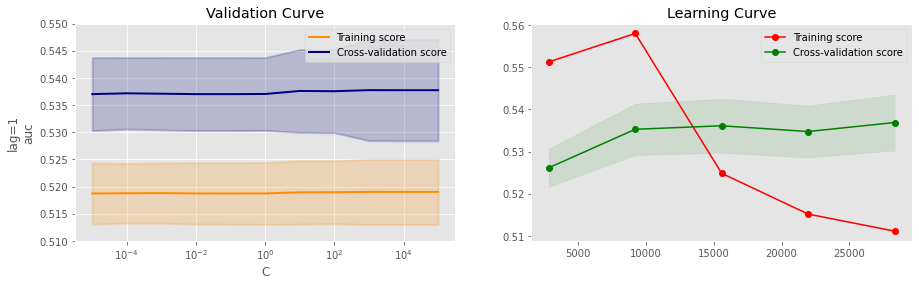

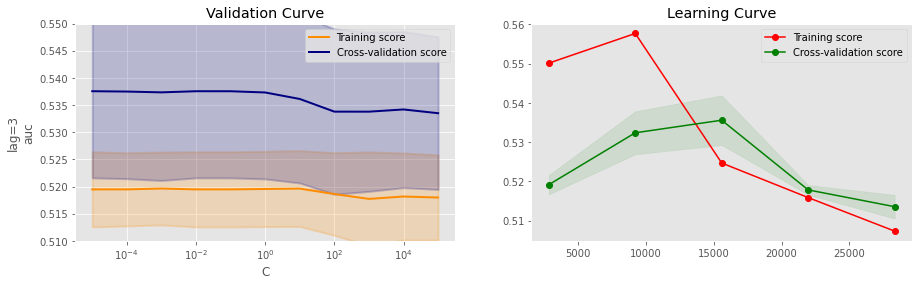

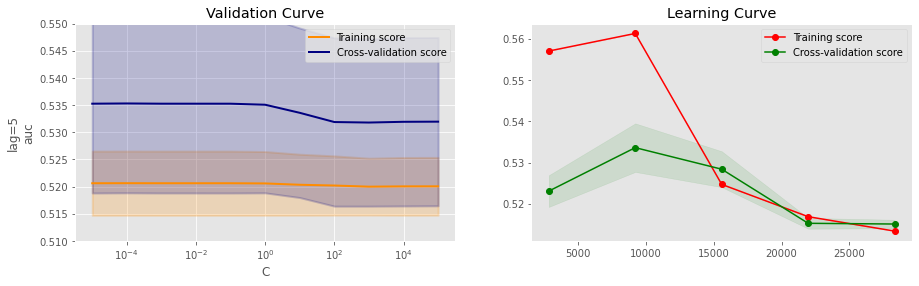

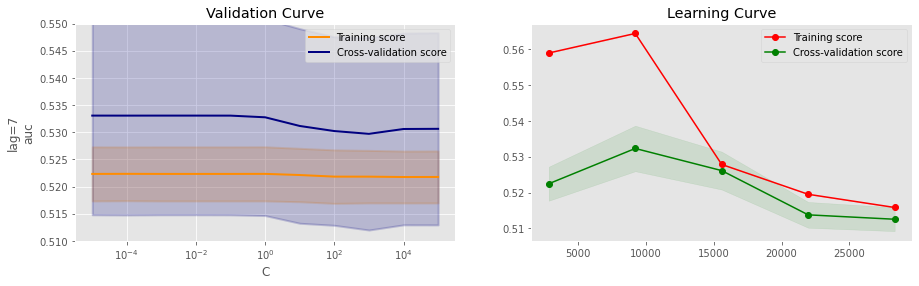

In [54]:
token = 'ETHBTC'
start = 0
end =  len(prices) #100000 #100 #len(prices) 
amount = 10
tc = 0.0
# model = 'logistic'

scibt = ScikitVectorBacktester(token, start, end, amount, tc)

split = 0.8
start_in = start
end_in = int(split * end)
start_out = end_in + 1
end_out = end

# scibt.test_score(start_in, end_in, start_out, end_out, lags=3)

# X_train, y_train = scibt.get_train_data(start, end, lags=3)
# print(X_train.shape)
# print(y_train.shape)

# tscv = TimeSeriesSplit(n_splits=5)
# for train, validate in tscv.split(X_train):
#     print(train, validate, '\n')
    
# scibt.plot_grid_search_cv_res(start_in, end_in, lags=3)

# print(f'\ntest_cross_val_score: ========')
# scibt.test_cross_val_score(start_in, end_in, lags=3)

# test results
# scibt.run_strategy(start_in, end_in, start_out, end_out, lags=3, use_grid_seach=True)
# scibt.plot_results()

# start_in, end_in, start_out, end_out, lags=3
for lag in [1,3,5,7]: #[1, 3, 5, 7, 9]:
    scibt.run_strategy(start_in, end_in, start_out, end_out, lags=lag, use_grid_seach=True)
#     scibt.plot_results()